          Метод  Время (сек)
   Pythonпотоки    25.396093
Python процессы    12.406827
  Cython потоки     0.013676
Cython процессы     0.103952


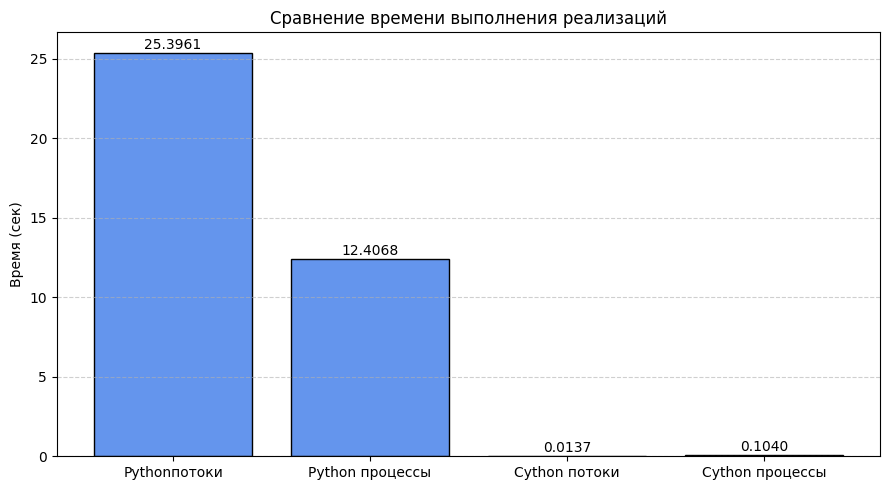

In [1]:
from threading import Thread
import queue
from multiprocessing import Pool
from ferma_fact import fermat_factorization
from ferma_fact_cy import fermat_factorization_cy  
import time
import matplotlib.pyplot as plt
import pandas as pd

TEST_LST = [101, 9973, 104729, 101909, 609133, 1300039, 9999991, 99999959, 99999971, 3000009, 700000133]

# Python потоки
def threaded_worker(q, results):
    while not q.empty():
        n = q.get()
        results.append(fermat_factorization(n))
        q.task_done()

def run_threaded_test():
    q = queue.Queue()
    results = []
    for n in TEST_LST:
        q.put(n)
    threads = []
    for _ in range(4):
        t = Thread(target=threaded_worker, args=(q, results))
        t.start()
        threads.append(t)
    for t in threads:
        t.join()
    return results

start = time.time()
_ = run_threaded_test()
end = time.time()
thread_time = end - start

# Python процессы
def run_process_test():
    with Pool(4) as p:
        return p.map(fermat_factorization, TEST_LST)

start = time.time()
_ = run_process_test()
end = time.time()
process_time = end - start

# Cython потоки
def threaded_worker_nogil(q, results):
    while not q.empty():
        n = q.get()
        results.append(fermat_factorization_cy(n))
        q.task_done()

def run_threaded_cython():
    q = queue.Queue()
    results = []
    for n in TEST_LST:
        q.put(n)
    threads = []
    for _ in range(4):
        t = Thread(target=threaded_worker_nogil, args=(q, results))
        t.start()
        threads.append(t)
    for t in threads:
        t.join()
    return results

start = time.time()
_ = run_threaded_cython()
end = time.time()
cython_thread_time = end - start

# Cython процессы
def run_process_cython():
    with Pool(4) as p:
        return p.map(fermat_factorization_cy, TEST_LST)

start = time.time()
_ = run_process_cython()
end = time.time()
cython_process_time = end - start

# Вывод таблицы
labels = ['Pythonпотоки', 'Python процессы', 'Cython потоки', 'Cython процессы']
times = [thread_time, process_time, cython_thread_time, cython_process_time]

df = pd.DataFrame({'Метод': labels, 'Время (сек)': times})
print(df.to_string(index=False))  # вывод таблицы в консоль

# График
plt.figure(figsize=(9, 5))
bars = plt.bar(labels, times, color='cornflowerblue', edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f"{yval:.4f}", ha='center', va='bottom')

plt.title("Сравнение времени выполнения реализаций")
plt.ylabel("Время (сек)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
